In [1]:
import pandas as pd
import numpy as np
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.colors as pc
from modified_spectral_method import recursive_spectral_method, create_correlation_matrix, calculate_C_g
from modified_louvain_method import *
from itertools import product
from collections import Counter

In [2]:
def split_data_by_interval(file_path, interval='2Q'):
    """
    Splits data into user-defined intervals.
    Args:
        file_path (str): Path to the CSV file containing the data.
        interval (str): Interval string (e.g., 'Q' for quarterly, '2Q' for two quarters).
    Returns:
        dict: A dictionary where keys are interval ranges, and values are dataframes for each interval.
    """
    # Load the data
    df = pd.read_csv(file_path, parse_dates=['Date'])
    
    # Ensure the 'Date' column is the index
    df.set_index('Date', inplace=True)
    
    # Group the data by the specified interval (default: two quarters)
    grouped = df.resample(interval)
    intervals = {
        f"{group.index.min().year}_Q{group.index.min().quarter} to {group.index.max().year}_Q{group.index.max().quarter}": group
        for _, group in grouped if not group.empty
    }
    
    return intervals


def analyze_intervals(file_path, interval='2YE', min_size=2, modularity_threshold=0.00001, method="louvain"):
    """
    Analyze communities for each interval and return results.
    Args:
        file_path (str): Path to the standardized returns file.
        interval (str): Resampling interval (e.g., '1Y', '2Y').
        min_size (int): Minimum size of communities.
        modularity_threshold (float): Threshold for modularity improvement.
    Returns:
        dict: Results containing communities and modularities for each interval.
    """
    # Split the data into intervals
    intervals = split_data_by_interval(file_path, interval=interval)
    results = {}

    # Analyze each interval
    for key, interval_data in intervals.items():
        # Ensure the data is sufficient
        if len(interval_data) < 2:
            print(f"Skipping interval {key} due to insufficient data.")
            continue
        
        # Compute correlation matrix
        correlation_matrix, T, N, company_names = create_correlation_matrix(interval_data)
        C_g = calculate_C_g(correlation_matrix, T, N)
        correlation_matrix = np.array(correlation_matrix)
        if method == "louvain":
            # Detect communities using modified Louvain method
            communities = modified_louvain(C_g, correlation_matrix)
    
            # Calculate modularities
            modularity = calculate_global_modularity(communities, C_g, correlation_matrix)
            # Assign modularities for consistency
            modularities = [modularity]  # Single modularity value in a list for consistency   
            # Map communities to company names
            company_communities = map_communities_to_company_names(communities, company_names)
        else:
            # Detect communities
            result_communities, company_communities, modularities = recursive_spectral_method(
                C_g, correlation_matrix, company_names, min_size=min_size, modularity_threshold=modularity_threshold
            )
        # Store results for this interval
        results[key] = {
            'communities': company_communities,
            'modularities': modularities
        }
        print(f"Interval {key}: Found {len(company_communities)} communities.")
    
    return results

if __name__ == '__main__':
    file_path = 'returns_standardized_S&P.csv'
    interval = '8Q'  # Change to '1Y', '6M', etc., for different intervals
    results = analyze_intervals(file_path, interval=interval, method = "spectral")

    # Example: Access communities and modularities for a specific interval
    for interval_key, result in results.items():
        print(f"Interval {interval_key}:")
        print(f"Communities: {result['communities']}")
        print(f"Modularities: {result['modularities']}")

C:\Users\iChin\AppData\Local\Temp\ipykernel_25464\780892429.py:17: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  grouped = df.resample(interval)


Interval 2001_Q4 to 2001_Q4: Found 3 communities.
Interval 2002_Q1 to 2003_Q4: Found 3 communities.
Interval 2004_Q1 to 2005_Q4: Found 5 communities.
Interval 2006_Q1 to 2007_Q4: Found 3 communities.
Interval 2008_Q1 to 2009_Q4: Found 3 communities.
Interval 2010_Q1 to 2011_Q3: Found 6 communities.
Interval 2001_Q4 to 2001_Q4:
Communities: [['AOS', 'ABT', 'AES', 'AFL', 'ALGN', 'LNT', 'ALL', 'MO', 'AEE', 'AEP', 'AME', 'ADI', 'AON', 'APA', 'ADM', 'AJG', 'T', 'ATO', 'AVB', 'AXON', 'BKR', 'BALL', 'BAC', 'BAX', 'BDX', 'BK', 'BA', 'BSX', 'BMY', 'BRO', 'BG', 'CPB', 'CAH', 'CCL', 'CAT', 'COR', 'CNP', 'CRL', 'SCHW', 'CVX', 'CB', 'CHD', 'CI', 'CINF', 'C', 'CLX', 'CMS', 'KO', 'CL', 'CAG', 'COP', 'ED', 'STZ', 'COO', 'CPRT', 'COST', 'CTRA', 'CVS', 'DVA', 'DVN', 'DLTR', 'D', 'DHI', 'DTE', 'DUK', 'EIX', 'EW', 'ETR', 'EOG', 'EQT', 'EFX', 'ERIE', 'EL', 'EG', 'EVRG', 'ES', 'EXC', 'XOM', 'FRT', 'FDX', 'FITB', 'FE', 'F', 'IT', 'GE', 'GD', 'GIS', 'GPN', 'GL', 'HAL', 'HAS', 'HSIC', 'HSY', 'HES', 'HOLX', 'HO

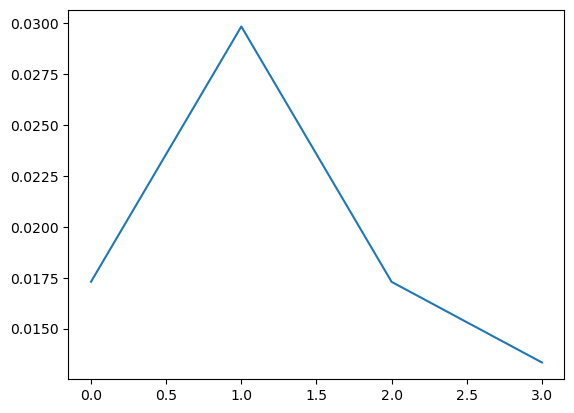

In [3]:
modularity_val = []
for interval_key, result in results.items():
        modularity_val.append(result['modularities'][0])
modularity_val = modularity_val[1:-1]
plt.plot(modularity_val)
plt.show()

In [4]:
def calculate_community_overlap(communities1, communities2):
    """
    Calculate overlap between two sets of communities.
    Args:
        communities1 (list of lists): Communities from interval 1.
        communities2 (list of lists): Communities from interval 2.
    Returns:
        list: Overlap scores for each pair of communities.
    """
    overlap_scores = []
    for i, comm1 in enumerate(communities1):
        for j, comm2 in enumerate(communities2):
            set1, set2 = set(comm1), set(comm2)
            intersection = len(set1 & set2)
            union = len(set1 | set2)
            jaccard_similarity = intersection / union if union > 0 else 0
            overlap_scores.append((i, j, jaccard_similarity))
    return overlap_scores

def compare_intervals(results, interval1, interval2):
    """
    Compare communities from two intervals.
    Args:
        results (dict): Results containing communities for each interval.
        interval1 (str): First interval key.
        interval2 (str): Second interval key.
    Returns:
        pd.DataFrame: DataFrame showing community overlaps.
    """
    communities1 = results[interval1]['communities']
    communities2 = results[interval2]['communities']
    
    overlap_scores = calculate_community_overlap(communities1, communities2)
    
    # Convert to a DataFrame for better visualization
    overlap_df = pd.DataFrame(overlap_scores, columns=['Community1', 'Community2', 'JaccardSimilarity'])
    overlap_df.sort_values(by='JaccardSimilarity', ascending=False, inplace=True)
    
    return overlap_df

# Example usage:
# Assuming `results` contains communities for each interval
interval1 = '2006_Q1 to 2007_Q4'
interval2 = '2010_Q1 to 2011_Q3'
overlap_df = compare_intervals(results, interval1, interval2)

# Display overlap
print(overlap_df)


    Community1  Community2  JaccardSimilarity
17           2           5           0.648069
8            1           2           0.556391
0            0           0           0.400000
2            0           2           0.097143
14           2           2           0.093333
3            0           3           0.087500
16           2           4           0.084906
5            0           5           0.064378
11           1           5           0.035433
6            1           0           0.032520
15           2           3           0.032407
4            0           4           0.021739
12           2           0           0.012245
13           2           1           0.009569
10           1           4           0.009259
7            1           1           0.000000
1            0           1           0.000000
9            1           3           0.000000


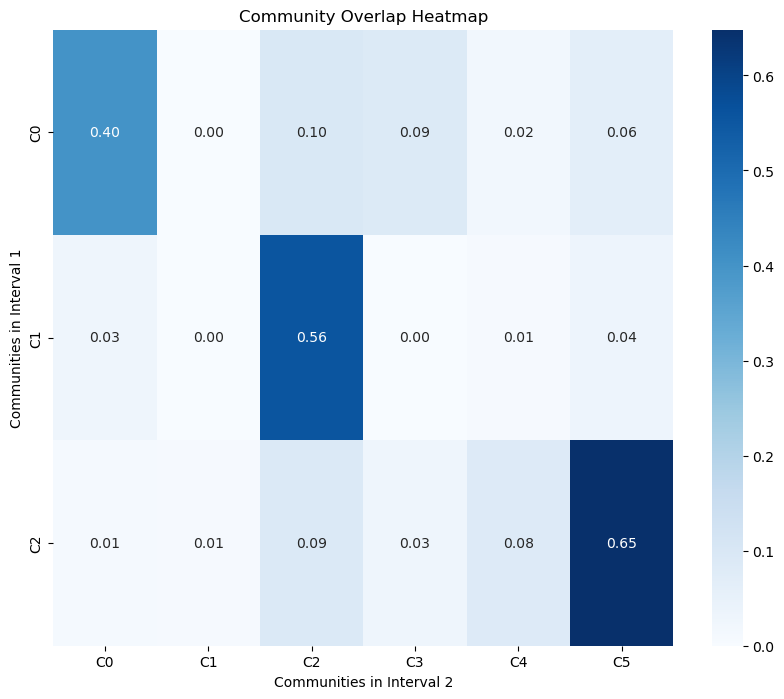

In [5]:
def plot_overlap_heatmap(communities1, communities2, overlap_scores):
    """
    Plot a heatmap of community overlaps.
    Args:
        communities1 (list): Communities from interval 1.
        communities2 (list): Communities from interval 2.
        overlap_scores (list): Overlap scores for each pair of communities.
    """
    # Create an overlap matrix
    overlap_matrix = np.zeros((len(communities1), len(communities2)))
    for i, j, score in overlap_scores:
        overlap_matrix[i, j] = score
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(overlap_matrix, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=[f'C{j}' for j in range(len(communities2))],
                yticklabels=[f'C{i}' for i in range(len(communities1))])
    plt.xlabel(f"Communities in Interval 2")
    plt.ylabel(f"Communities in Interval 1")
    plt.title("Community Overlap Heatmap")
    plt.show()

# Example usage:
overlap_scores = calculate_community_overlap(results[interval1]['communities'], results[interval2]['communities'])
plot_overlap_heatmap(results[interval1]['communities'], results[interval2]['communities'], overlap_scores)

In [6]:
def compute_entropy(partition, total_elements):
    """
    Compute the entropy of a partition.
    Args:
        partition (list of lists): List of communities, each a list of elements.
        total_elements (int): Total number of elements in the dataset.
    Returns:
        float: Entropy of the partition.
    """
    # Filter out empty communities
    partition = [community for community in partition if community]

    # Calculate probabilities
    probabilities = [len(community) / total_elements for community in partition]

    # Add a small epsilon to avoid numerical instability
    epsilon = 0
    return -sum(p * np.log2(p + epsilon) for p in probabilities if p > 0)

def compute_mutual_information(partition1, partition2, total_elements):
    """
    Compute the mutual information between two partitions.
    Args:
        partition1 (list of lists): First partition.
        partition2 (list of lists): Second partition.
        total_elements (int): Total number of elements in the dataset.
    Returns:
        float: Mutual information between the partitions.
    """
    mutual_information = 0
    epsilon = 0  # Numerical stability
    for community1 in partition1:
        set1 = set(community1)  # Convert the first community to a set
        # print('in set1', set1)
        p_set1 = len(set1)/total_elements
        for community2 in partition2:
            set2 = set(community2)  # Convert the second community to a set
            p_set2 = len(set2)/total_elements
            intersection = set1 & set2  # Compute the intersection
            joint_prob = len(intersection) / total_elements #P(k, k')
            if joint_prob > 0:
                mutual_information += joint_prob * np.log2(joint_prob/(p_set1*p_set2))
            else:
                continue
            # print("joint_prob", joint_prob)
            # print("mutual info", mutual_information)
            
    return mutual_information

def compute_vi(partition1, partition2):
    """
    Compute the Variation of Information (VI) between two partitions.
    Args:
        partition1 (list of lists): First partition.
        partition2 (list of lists): Second partition.
    Returns:
        float: Variation of Information (VI) between the partitions.
    """

    # Calculate the total number of unique elements across both partitions
    unique_elements = set()
    for community in partition1:
        unique_elements.update(community)
    for community in partition2:
        unique_elements.update(community)
    total_elements = len(unique_elements)

    # Compute entropies for both partitions
    h1 = compute_entropy(partition1, total_elements) # H(C)
    h2 = compute_entropy(partition2, total_elements) # H(C')

    # Compute mutual information between the partitions
    mutual_info = compute_mutual_information(partition1, partition2, total_elements) # I(C, C')

    # Return the Variation of Information
    VI = (h1 - mutual_info) + (h2 - mutual_info)
    return VI

def compute_normalized_vi(partition1, partition2):
    """
    Compute the Normalized Variation of Information (VI) between two partitions.
    Args:
        partition1 (list of lists): First partition.
        partition2 (list of lists): Second partition.
    Returns:
        float: Normalized VI between the partitions.
    """
    # Compute the unnormalized VI
    vi = compute_vi(partition1, partition2)

    # Calculate total entropy
    unique_elements = set()
    for community in partition1:
        unique_elements.update(community)
    for community in partition2:
        unique_elements.update(community)
    total_elements = len(unique_elements)

    h1 = compute_entropy(partition1, total_elements)
    h2 = compute_entropy(partition2, total_elements)

    total_entropy = h1 + h2

    # Normalize VI
    normalized_vi = vi / np.log2(total_elements)
    return normalized_vi

# Comparing communities across intervals
def compare_communities_across_intervals(results):
    """
    Compare community structures across intervals using VI.
    Args:
        results (dict): Results from analyze_intervals, containing communities for each interval.
    Returns:
        dict: Pairwise VI scores for all interval pairs.
    """
    intervals = list(results.keys())
    vi_scores = {}

    for i in range(len(intervals)):
        for j in range(i, len(intervals)):
            interval1, interval2 = intervals[i], intervals[j]
            partition1 = results[interval1]['communities']
            partition2 = results[interval2]['communities']
            vi = compute_vi(partition1, partition2)
            vi_scores[(interval1, interval2)] = vi
            print(f"VI between {interval1} and {interval2}: {vi}")
    
    return vi_scores

def compare_communities_across_intervals_normalized(results):
    """
    Compare community structures across intervals using normalized VI.
    Args:
        results (dict): Results from analyze_intervals, containing communities for each interval.
    Returns:
        dict: Pairwise normalized VI scores for all interval pairs.
    """
    intervals = list(results.keys())
    normalized_vi_scores = {}
    normalized_vi_list = []

    for i in range(len(intervals)):
        for j in range(i, len(intervals)):
            interval1, interval2 = intervals[i], intervals[j]
            partition1 = results[interval1]['communities']
            partition2 = results[interval2]['communities']
            normalized_vi = compute_normalized_vi(partition1, partition2)
            normalized_vi_scores[(interval1, interval2)] = normalized_vi
            normalized_vi_list.append(normalized_vi)
            print(f"Normalized VI between {interval1} and {interval2}: {normalized_vi}")
    
    return normalized_vi_scores, normalized_vi_list

# Example usage
normalized_vi_scores, normalized_vi_list = compare_communities_across_intervals_normalized(results)

vi_scores = compare_communities_across_intervals(results)


Normalized VI between 2001_Q4 to 2001_Q4 and 2001_Q4 to 2001_Q4: 0.0
Normalized VI between 2001_Q4 to 2001_Q4 and 2002_Q1 to 2003_Q4: 0.2904723612360016
Normalized VI between 2001_Q4 to 2001_Q4 and 2004_Q1 to 2005_Q4: 0.34889036733279566
Normalized VI between 2001_Q4 to 2001_Q4 and 2006_Q1 to 2007_Q4: 0.3139662853165661
Normalized VI between 2001_Q4 to 2001_Q4 and 2008_Q1 to 2009_Q4: 0.31451772002544537
Normalized VI between 2001_Q4 to 2001_Q4 and 2010_Q1 to 2011_Q3: 0.336689450928959
Normalized VI between 2002_Q1 to 2003_Q4 and 2002_Q1 to 2003_Q4: 5.205361076694684e-17
Normalized VI between 2002_Q1 to 2003_Q4 and 2004_Q1 to 2005_Q4: 0.26667665628206
Normalized VI between 2002_Q1 to 2003_Q4 and 2006_Q1 to 2007_Q4: 0.28581346502266947
Normalized VI between 2002_Q1 to 2003_Q4 and 2008_Q1 to 2009_Q4: 0.29463539434344554
Normalized VI between 2002_Q1 to 2003_Q4 and 2010_Q1 to 2011_Q3: 0.31705592942973254
Normalized VI between 2004_Q1 to 2005_Q4 and 2004_Q1 to 2005_Q4: 0.0
Normalized VI bet

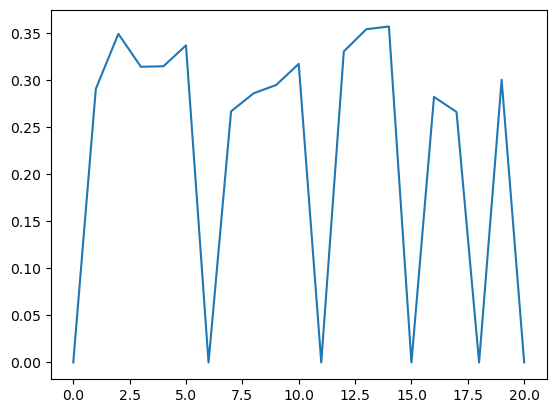

In [7]:
plt.plot(normalized_vi_list)

In [8]:
len(correlation_matrix)

NameError: name 'correlation_matrix' is not defined